In [2]:
from sqlalchemy import create_engine, inspect,func
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
from sqlalchemy import Column, Integer, String, Float, DateTime
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")
# inspector = inspect(engine)
Base.prepare(engine,reflect = True)

In [4]:
from sqlalchemy.orm import Session
session = Session(bind = engine)
# inspector.get_table_names()
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station


In [6]:
first_data = session.query(Measurement).first()
first_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1162e1240>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [5]:
precip_data = session.query(Station).first()
precip_data.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1162cb860>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [7]:
query_date = session.query(Measurement.date).order_by((Measurement.date).desc()).first()
query_date


('2017-08-23')

In [8]:
days_ago = query_date = dt.date(2017,8,23) - dt.timedelta(days = 366)
days_ago

datetime.date(2016, 8, 22)

In [9]:
#Design a query to retrieve the last 12 months of precipitation data.
prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>days_ago).all()
prcp_df = pd.DataFrame(prcp, columns = ["Date", "Precipitation"])
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


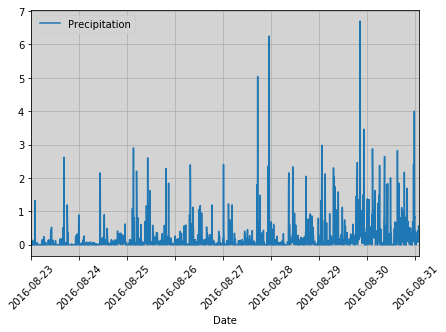

In [55]:
graph = prcp_df.plot()
plt.tight_layout()
plt.grid(True)
graph.set_xticklabels(prcp_df["Date"], rotation=45)
plt.xlabel("Date")
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.show()

In [28]:
#Design a query to calculate the total number of stations.
total_stations = session.query(Station.station).count()
total_stations

9

In [39]:
# Design a query to find the most active stations.
sel = [Station.name, Measurement.station, func.count(Measurement.tobs)]
active = session.query(*sel).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
active

('WAIHEE 837.5, HI US', 'USC00519281', 2772)

In [56]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
tobs = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>days_ago).filter(Measurement.station == active[1]).all()
tobs_df = pd.DataFrame(tobs,columns=["date","tobs"])
tobs_df.head()

,date,tobs
0,2016-08-23,77
1,2016-08-24,77
2,2016-08-25,80
3,2016-08-26,80
4,2016-08-27,75


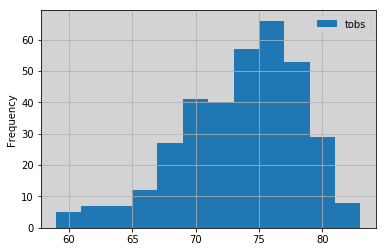

In [57]:
# Plot the results as a histogram with bins=12
tobs_df.plot.hist(bins = 12)
plt.grid(True)
plt.show()

[datetime.date(2017, 7, 24), datetime.date(2017, 8, 6)]


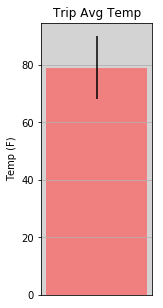

In [182]:
from scipy.stats import sem
def calc_temps(start_date, end_date):
    dates = [start_date, end_date]
    last_year_date=[]
    for x in range(len(dates)):
        split_start_date = dates[x].split("-")
        last_year_date.append(dt.date(int(split_start_date[0]),int(split_start_date[1]),int(split_start_date[2]))-dt.timedelta(days = 365))
    print(last_year_date)
                              
    temperature = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs))\
    .filter(Measurement.date >= last_year_date[0]).filter(Measurement.date<=last_year_date[1]).all()
    temp = list(np.ravel(temperature))
    
    plt.figure(figsize = (2,5))
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.bar(1, temp[1], color = "lightcoral",yerr = (temp[2] - temp[0]),tick_label = "")
    plt.grid()
    plt.xticks([])
    plt.show()

calc_temps("2018-07-24","2018-08-06")


In [189]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
# def tem(start,end):
sel = [func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)]
temperatures = session.query(*sel).filter(Measurement.date >="2016-08-23" ).filter(Measurement.date<="2016-08-27" ).all()

print(temperatures)
# tem("8//1/17","9/1/17")

[(84, 73, 78.63333333333334)]


In [179]:
# Create a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
def daily_normals(query_date):
    temperature = session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.date >= query_date).all()
    t_list = list(np.ravel(temperature))
    tempp = [
        {"Minimum temperature": t_list[1]},
        {"Maximum temperature": t_list[0]},
        {"Average temperature": t_list[2]}]
        
    return tempp

daily_normals("08-01-17")

[{'Minimum temperature': 53.0},
 {'Maximum temperature': 87.0},
 {'Average temperature': 72.994862729934269}]

In [14]:
# columns = inspector.get_columns("measurement")
# for column in columns:
#     print(column['name'])

id
station
date
prcp
tobs


In [15]:
# # class Measure(Base):
#     __tablename__ = 'measurement'
#     id = Column(Integer, primary_key = True)
#     station = Column(String)
#     date = Column(Integer)
#     prcp = Column(Float)
#     tobs = Column(Float)
    

In [17]:
data = engine.execute("select date from measurement;")
for row in data:
    print(row)

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-07',)
('2010-01-08',)
('2010-01-09',)
('2010-01-10',)
('2010-01-11',)
('2010-01-12',)
('2010-01-14',)
('2010-01-15',)
('2010-01-16',)
('2010-01-17',)
('2010-01-18',)
('2010-01-19',)
('2010-01-20',)
('2010-01-21',)
('2010-01-22',)
('2010-01-23',)
('2010-01-24',)
('2010-01-25',)
('2010-01-26',)
('2010-01-27',)
('2010-01-28',)
('2010-01-31',)
('2010-02-01',)
('2010-02-04',)
('2010-02-05',)
('2010-02-06',)
('2010-02-07',)
('2010-02-08',)
('2010-02-09',)
('2010-02-11',)
('2010-02-12',)
('2010-02-13',)
('2010-02-14',)
('2010-02-15',)
('2010-02-16',)
('2010-02-17',)
('2010-02-20',)
('2010-02-21',)
('2010-02-22',)
('2010-02-23',)
('2010-02-24',)
('2010-02-25',)
('2010-02-26',)
('2010-02-28',)
('2010-03-01',)
('2010-03-02',)
('2010-03-03',)
('2010-03-04',)
('2010-03-05',)
('2010-03-06',)
('2010-03-07',)
('2010-03-08',)
('2010-03-09',)
('2010-03-12',)
('2010-03-13',)
('2010-03-14',)
('2010-03-15',)
('2010-03-17',)
('2010-0

('2012-06-25',)
('2012-06-26',)
('2012-06-27',)
('2012-06-28',)
('2012-06-29',)
('2012-06-30',)
('2012-07-01',)
('2012-07-02',)
('2012-07-03',)
('2012-07-04',)
('2012-07-05',)
('2012-07-06',)
('2012-07-07',)
('2012-07-08',)
('2012-07-10',)
('2012-07-11',)
('2012-07-12',)
('2012-07-13',)
('2012-07-14',)
('2012-07-15',)
('2012-07-16',)
('2012-07-17',)
('2012-07-18',)
('2012-07-19',)
('2012-07-20',)
('2012-07-21',)
('2012-07-22',)
('2012-07-23',)
('2012-07-24',)
('2012-07-25',)
('2012-07-26',)
('2012-07-27',)
('2012-07-28',)
('2012-07-29',)
('2012-07-30',)
('2012-07-31',)
('2012-08-01',)
('2012-08-02',)
('2012-08-03',)
('2012-08-04',)
('2012-08-05',)
('2012-08-06',)
('2012-08-07',)
('2012-08-08',)
('2012-08-09',)
('2012-08-10',)
('2012-08-11',)
('2012-08-12',)
('2012-08-13',)
('2012-08-14',)
('2012-08-15',)
('2012-08-16',)
('2012-08-17',)
('2012-08-20',)
('2012-08-21',)
('2012-08-22',)
('2012-08-23',)
('2012-08-24',)
('2012-08-25',)
('2012-08-26',)
('2012-08-27',)
('2012-08-28',)
('2012-0

('2016-07-14',)
('2016-07-15',)
('2016-07-16',)
('2016-07-17',)
('2016-07-18',)
('2016-07-19',)
('2016-07-20',)
('2016-07-21',)
('2016-07-22',)
('2016-07-23',)
('2016-07-24',)
('2016-07-25',)
('2016-07-26',)
('2016-07-27',)
('2016-07-28',)
('2016-07-29',)
('2016-07-30',)
('2016-07-31',)
('2016-08-01',)
('2016-08-02',)
('2016-08-03',)
('2016-08-04',)
('2016-08-05',)
('2016-08-06',)
('2016-08-07',)
('2016-08-08',)
('2016-08-09',)
('2016-08-10',)
('2016-08-11',)
('2016-08-12',)
('2016-08-13',)
('2016-08-14',)
('2016-08-15',)
('2016-08-16',)
('2016-08-17',)
('2016-08-18',)
('2016-08-19',)
('2016-08-20',)
('2016-08-21',)
('2016-08-22',)
('2016-08-23',)
('2016-08-24',)
('2016-08-25',)
('2016-08-26',)
('2016-08-27',)
('2016-08-28',)
('2016-08-29',)
('2016-08-30',)
('2016-08-31',)
('2016-09-01',)
('2016-09-02',)
('2016-09-03',)
('2016-09-04',)
('2016-09-07',)
('2016-09-08',)
('2016-09-09',)
('2016-09-10',)
('2016-09-11',)
('2016-09-12',)
('2016-09-13',)
('2016-09-14',)
('2016-09-15',)
('2016-0

('2012-11-21',)
('2012-11-22',)
('2012-11-23',)
('2012-11-24',)
('2012-11-25',)
('2012-11-26',)
('2012-11-27',)
('2012-11-28',)
('2012-11-29',)
('2012-11-30',)
('2012-12-01',)
('2012-12-02',)
('2012-12-03',)
('2012-12-04',)
('2012-12-05',)
('2012-12-06',)
('2012-12-07',)
('2012-12-08',)
('2012-12-09',)
('2012-12-10',)
('2012-12-11',)
('2012-12-12',)
('2012-12-13',)
('2012-12-14',)
('2012-12-15',)
('2012-12-16',)
('2012-12-17',)
('2012-12-18',)
('2012-12-19',)
('2012-12-20',)
('2012-12-21',)
('2012-12-22',)
('2012-12-23',)
('2012-12-24',)
('2012-12-25',)
('2012-12-26',)
('2012-12-27',)
('2012-12-28',)
('2012-12-29',)
('2012-12-30',)
('2012-12-31',)
('2013-01-01',)
('2013-01-02',)
('2013-01-03',)
('2013-01-04',)
('2013-01-05',)
('2013-01-06',)
('2013-01-07',)
('2013-01-08',)
('2013-01-09',)
('2013-01-10',)
('2013-01-11',)
('2013-01-14',)
('2013-01-15',)
('2013-01-16',)
('2013-01-17',)
('2013-01-18',)
('2013-01-19',)
('2013-01-20',)
('2013-01-21',)
('2013-01-22',)
('2013-01-23',)
('2013-0

('2016-07-02',)
('2016-07-03',)
('2016-07-04',)
('2016-07-05',)
('2016-07-06',)
('2016-07-07',)
('2016-07-08',)
('2016-07-09',)
('2016-07-10',)
('2016-07-11',)
('2016-07-12',)
('2016-07-13',)
('2016-07-14',)
('2016-07-15',)
('2016-07-16',)
('2016-07-17',)
('2016-07-18',)
('2016-07-19',)
('2016-07-20',)
('2016-07-21',)
('2016-07-22',)
('2016-07-23',)
('2016-07-24',)
('2016-07-25',)
('2016-07-26',)
('2016-07-27',)
('2016-07-28',)
('2016-07-29',)
('2016-07-30',)
('2016-07-31',)
('2016-08-01',)
('2016-08-02',)
('2016-08-03',)
('2016-08-04',)
('2016-08-05',)
('2016-08-06',)
('2016-08-07',)
('2016-08-08',)
('2016-08-09',)
('2016-08-10',)
('2016-08-11',)
('2016-08-12',)
('2016-08-13',)
('2016-08-14',)
('2016-08-15',)
('2016-08-16',)
('2016-08-17',)
('2016-08-18',)
('2016-08-19',)
('2016-08-20',)
('2016-08-21',)
('2016-08-22',)
('2016-08-23',)
('2016-08-24',)
('2016-08-25',)
('2016-08-26',)
('2016-08-27',)
('2016-08-28',)
('2016-08-29',)
('2016-08-30',)
('2016-08-31',)
('2016-09-01',)
('2016-0

('2015-12-11',)
('2015-12-12',)
('2015-12-13',)
('2015-12-14',)
('2015-12-15',)
('2015-12-16',)
('2015-12-17',)
('2015-12-18',)
('2015-12-19',)
('2015-12-22',)
('2015-12-23',)
('2015-12-28',)
('2015-12-29',)
('2016-01-01',)
('2016-01-02',)
('2016-01-03',)
('2016-01-04',)
('2016-01-05',)
('2016-01-06',)
('2016-01-07',)
('2016-01-08',)
('2016-01-09',)
('2016-01-12',)
('2016-01-13',)
('2016-01-14',)
('2016-01-15',)
('2016-01-16',)
('2016-01-17',)
('2016-01-18',)
('2016-01-19',)
('2016-01-20',)
('2016-01-21',)
('2016-01-22',)
('2016-01-23',)
('2016-01-24',)
('2016-01-25',)
('2016-01-26',)
('2016-01-27',)
('2016-01-28',)
('2016-01-29',)
('2016-01-30',)
('2016-02-02',)
('2016-02-04',)
('2016-02-05',)
('2016-02-06',)
('2016-02-07',)
('2016-02-08',)
('2016-02-09',)
('2016-02-10',)
('2016-02-11',)
('2016-02-12',)
('2016-02-13',)
('2016-02-14',)
('2016-02-15',)
('2016-02-16',)
('2016-02-17',)
('2016-02-18',)
('2016-02-19',)
('2016-02-20',)
('2016-02-23',)
('2016-02-24',)
('2016-02-25',)
('2016-0

('2010-09-27',)
('2010-09-28',)
('2010-10-01',)
('2010-10-02',)
('2010-10-03',)
('2010-10-04',)
('2010-10-05',)
('2010-10-06',)
('2010-10-07',)
('2010-10-08',)
('2010-10-25',)
('2010-10-26',)
('2010-10-27',)
('2010-10-28',)
('2010-10-29',)
('2010-10-30',)
('2010-10-31',)
('2010-11-01',)
('2010-11-02',)
('2010-11-03',)
('2010-11-04',)
('2010-11-05',)
('2010-11-16',)
('2010-11-18',)
('2010-11-19',)
('2010-11-23',)
('2010-11-24',)
('2010-12-03',)
('2010-12-06',)
('2010-12-07',)
('2010-12-08',)
('2010-12-09',)
('2010-12-10',)
('2010-12-11',)
('2010-12-14',)
('2010-12-15',)
('2010-12-16',)
('2011-01-05',)
('2011-01-06',)
('2011-01-07',)
('2011-01-11',)
('2011-01-12',)
('2011-01-13',)
('2011-01-14',)
('2011-01-19',)
('2011-01-20',)
('2011-01-21',)
('2011-01-25',)
('2011-01-26',)
('2011-01-27',)
('2011-01-28',)
('2011-02-01',)
('2011-02-02',)
('2011-02-03',)
('2011-02-04',)
('2011-02-10',)
('2011-02-11',)
('2011-02-15',)
('2011-02-16',)
('2011-02-17',)
('2011-02-18',)
('2011-02-23',)
('2011-0

('2013-09-14',)
('2013-09-15',)
('2013-09-16',)
('2013-09-17',)
('2013-09-18',)
('2013-09-19',)
('2013-09-20',)
('2013-09-23',)
('2013-09-26',)
('2013-09-27',)
('2013-09-28',)
('2013-09-29',)
('2013-09-30',)
('2013-10-01',)
('2013-10-02',)
('2013-10-03',)
('2013-10-04',)
('2013-10-07',)
('2013-10-08',)
('2013-10-09',)
('2013-10-10',)
('2013-10-11',)
('2013-10-12',)
('2013-10-13',)
('2013-10-14',)
('2013-10-15',)
('2013-10-16',)
('2013-10-17',)
('2013-10-18',)
('2013-10-19',)
('2013-10-20',)
('2013-10-21',)
('2013-10-22',)
('2013-10-23',)
('2013-10-24',)
('2013-10-25',)
('2013-10-26',)
('2013-10-29',)
('2013-10-30',)
('2013-10-31',)
('2013-11-01',)
('2013-11-02',)
('2013-11-03',)
('2013-11-04',)
('2013-11-05',)
('2013-11-06',)
('2013-11-07',)
('2013-11-08',)
('2013-11-09',)
('2013-11-10',)
('2013-11-11',)
('2013-11-12',)
('2013-11-13',)
('2013-11-14',)
('2013-11-15',)
('2013-11-21',)
('2013-11-22',)
('2013-11-23',)
('2013-11-24',)
('2013-11-25',)
('2013-11-26',)
('2013-11-27',)
('2013-1

('2011-01-08',)
('2011-01-09',)
('2011-01-10',)
('2011-01-11',)
('2011-01-12',)
('2011-01-13',)
('2011-01-14',)
('2011-01-15',)
('2011-01-16',)
('2011-01-17',)
('2011-01-18',)
('2011-01-19',)
('2011-01-20',)
('2011-01-21',)
('2011-01-22',)
('2011-01-23',)
('2011-01-24',)
('2011-01-25',)
('2011-01-26',)
('2011-01-27',)
('2011-01-28',)
('2011-01-29',)
('2011-01-30',)
('2011-01-31',)
('2011-02-01',)
('2011-02-02',)
('2011-02-03',)
('2011-02-04',)
('2011-02-05',)
('2011-02-06',)
('2011-02-07',)
('2011-02-08',)
('2011-02-09',)
('2011-02-10',)
('2011-02-11',)
('2011-02-12',)
('2011-02-13',)
('2011-02-14',)
('2011-02-15',)
('2011-02-16',)
('2011-02-17',)
('2011-02-18',)
('2011-02-19',)
('2011-02-20',)
('2011-02-21',)
('2011-02-22',)
('2011-02-23',)
('2011-02-24',)
('2011-02-25',)
('2011-02-26',)
('2011-02-27',)
('2011-02-28',)
('2011-03-01',)
('2011-03-02',)
('2011-03-03',)
('2011-03-04',)
('2011-03-05',)
('2011-03-06',)
('2011-03-07',)
('2011-03-08',)
('2011-03-09',)
('2011-03-10',)
('2011-0

('2015-05-05',)
('2015-05-06',)
('2015-05-07',)
('2015-05-08',)
('2015-05-09',)
('2015-05-10',)
('2015-05-11',)
('2015-05-12',)
('2015-05-13',)
('2015-05-14',)
('2015-05-15',)
('2015-05-16',)
('2015-05-17',)
('2015-05-18',)
('2015-05-19',)
('2015-05-20',)
('2015-05-21',)
('2015-05-22',)
('2015-05-23',)
('2015-05-24',)
('2015-05-25',)
('2015-05-26',)
('2015-05-27',)
('2015-05-28',)
('2015-05-29',)
('2015-05-30',)
('2015-05-31',)
('2015-06-01',)
('2015-06-02',)
('2015-06-03',)
('2015-06-04',)
('2015-06-05',)
('2015-06-06',)
('2015-06-07',)
('2015-06-08',)
('2015-06-09',)
('2015-06-10',)
('2015-06-11',)
('2015-06-12',)
('2015-06-13',)
('2015-06-14',)
('2015-06-15',)
('2015-06-16',)
('2015-06-17',)
('2015-06-18',)
('2015-06-19',)
('2015-06-20',)
('2015-06-21',)
('2015-06-22',)
('2015-06-23',)
('2015-06-24',)
('2015-06-25',)
('2015-06-26',)
('2015-06-27',)
('2015-06-28',)
('2015-06-29',)
('2015-06-30',)
('2015-07-01',)
('2015-07-02',)
('2015-07-03',)
('2015-07-04',)
('2015-07-05',)
('2015-0

('2010-10-29',)
('2010-10-30',)
('2010-10-31',)
('2010-11-01',)
('2010-11-02',)
('2010-11-03',)
('2010-11-04',)
('2010-11-05',)
('2010-11-06',)
('2010-11-07',)
('2010-11-08',)
('2010-11-09',)
('2010-11-10',)
('2010-11-11',)
('2010-11-12',)
('2010-11-13',)
('2010-11-14',)
('2010-11-15',)
('2010-11-16',)
('2010-11-17',)
('2010-11-18',)
('2010-11-19',)
('2010-11-20',)
('2010-11-21',)
('2010-11-22',)
('2010-11-23',)
('2010-11-24',)
('2010-11-25',)
('2010-11-26',)
('2010-11-27',)
('2010-11-28',)
('2010-11-29',)
('2010-11-30',)
('2010-12-01',)
('2010-12-02',)
('2010-12-03',)
('2010-12-04',)
('2010-12-05',)
('2010-12-06',)
('2010-12-07',)
('2010-12-08',)
('2010-12-09',)
('2010-12-10',)
('2010-12-11',)
('2010-12-12',)
('2010-12-13',)
('2010-12-14',)
('2010-12-15',)
('2010-12-16',)
('2010-12-17',)
('2010-12-18',)
('2010-12-19',)
('2010-12-20',)
('2010-12-21',)
('2010-12-22',)
('2010-12-23',)
('2010-12-24',)
('2010-12-25',)
('2010-12-26',)
('2010-12-27',)
('2010-12-28',)
('2010-12-29',)
('2010-1

('2010-09-15',)
('2010-09-16',)
('2010-09-17',)
('2010-09-18',)
('2010-09-19',)
('2010-09-20',)
('2010-09-21',)
('2010-09-22',)
('2010-09-23',)
('2010-09-24',)
('2010-09-25',)
('2010-09-26',)
('2010-09-27',)
('2010-09-28',)
('2010-09-29',)
('2010-09-30',)
('2010-10-01',)
('2010-10-02',)
('2010-10-03',)
('2010-10-04',)
('2010-10-05',)
('2010-10-06',)
('2010-10-07',)
('2010-10-08',)
('2010-10-09',)
('2010-10-10',)
('2010-10-11',)
('2010-10-12',)
('2010-10-13',)
('2010-10-14',)
('2010-10-15',)
('2010-10-16',)
('2010-10-17',)
('2010-10-18',)
('2010-10-19',)
('2010-10-20',)
('2010-10-21',)
('2010-10-22',)
('2010-10-23',)
('2010-10-24',)
('2010-10-25',)
('2010-10-26',)
('2010-10-27',)
('2010-10-28',)
('2010-10-29',)
('2010-10-30',)
('2010-10-31',)
('2010-11-01',)
('2010-11-02',)
('2010-11-03',)
('2010-11-04',)
('2010-11-05',)
('2010-11-06',)
('2010-11-07',)
('2010-11-08',)
('2010-11-09',)
('2010-11-10',)
('2010-11-11',)
('2010-11-12',)
('2010-11-13',)
('2010-11-14',)
('2010-11-15',)
('2010-1

('2015-05-05',)
('2015-05-06',)
('2015-05-07',)
('2015-05-08',)
('2015-05-09',)
('2015-05-10',)
('2015-05-11',)
('2015-05-12',)
('2015-05-13',)
('2015-05-14',)
('2015-05-15',)
('2015-05-16',)
('2015-05-17',)
('2015-05-18',)
('2015-05-19',)
('2015-05-20',)
('2015-05-21',)
('2015-05-22',)
('2015-05-23',)
('2015-05-24',)
('2015-05-25',)
('2015-05-26',)
('2015-05-27',)
('2015-05-28',)
('2015-05-29',)
('2015-05-30',)
('2015-05-31',)
('2015-06-01',)
('2015-06-02',)
('2015-06-03',)
('2015-06-04',)
('2015-06-05',)
('2015-06-06',)
('2015-06-07',)
('2015-06-08',)
('2015-06-09',)
('2015-06-10',)
('2015-06-13',)
('2015-06-14',)
('2015-06-15',)
('2015-06-16',)
('2015-06-17',)
('2015-06-18',)
('2015-06-19',)
('2015-06-20',)
('2015-06-21',)
('2015-06-22',)
('2015-06-23',)
('2015-06-24',)
('2015-06-25',)
('2015-06-26',)
('2015-06-27',)
('2015-06-28',)
('2015-06-29',)
('2015-06-30',)
('2015-07-01',)
('2015-07-02',)
('2015-07-03',)
('2015-07-04',)
('2015-07-05',)
('2015-07-06',)
('2015-07-07',)
('2015-0

In [ ]:
session.query(hawaii.date>)